This script is used to load netvlad model and generate netvlad_result.txt and netvlad_result_faiss.txt 

In [1]:
from __future__ import print_function
import argparse
from math import log10, ceil
import random, shutil, json
from os.path import join, exists, isfile, realpath, dirname
from os import makedirs, remove, chdir, environ
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data.dataset import Subset
import torchvision.transforms as transforms
from PIL import Image
from datetime import datetime
import torchvision.datasets as datasets
import torchvision.models as models
# import h5py
# import faiss

# from tensorboardX import SummaryWriter
import numpy as np

import netvlad

/home/ds/miniconda3/envs/netvlad/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
def cosine_similarity(v1, v2):
    """Compute the cosine similarity between two VLAD encodings"""
    v1_norm = v1 / torch.linalg.norm(v1)
    v2_norm = v2 / torch.linalg.norm(v2)
    return torch.dot(v1_norm, v2_norm).item()

def euclidean_distance(v1, v2):
    return torch.dist(v1, v2, p=2).item()


print(f'Is cuda available? {torch.cuda.is_available()}')    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load VGG16 as Encoder
encoder_dim = 512  # VGG16 output dimension
encoder = models.vgg16(pretrained=False)
layers = list(encoder.features.children())[:-2]  # Use the feature extraction layers of VGG16
encoder = nn.Sequential(*layers)
encoder = encoder.to(device)

# Load NetVLAD layer as pooling
net_vlad = netvlad.NetVLAD(num_clusters=64, dim=encoder_dim, vladv2=False).to(device)

# Load the checkpoint
checkpoint_path = 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'  # Update this path with your actual checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Separate encoder and net_vlad weights
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in checkpoint['state_dict'].items() if 'encoder' in k}
netvlad_state_dict = {k.replace('pool.', ''): v for k, v in checkpoint['state_dict'].items() if 'pool' in k}

# Load the encoder state dictionary
missing_encoder_keys, unexpected_encoder_keys = encoder.load_state_dict(encoder_state_dict, strict=False)
print("Encoder - Missing keys:", missing_encoder_keys)
print("Encoder - Unexpected keys:", unexpected_encoder_keys)

# Load the NetVLAD state dictionary
missing_vlad_keys, unexpected_vlad_keys = net_vlad.load_state_dict(netvlad_state_dict, strict=False)
print("NetVLAD - Missing keys:", missing_vlad_keys)
print("NetVLAD - Unexpected keys:", unexpected_vlad_keys)

Is cuda available? True
Encoder - Missing keys: []
Encoder - Unexpected keys: []
NetVLAD - Missing keys: []
NetVLAD - Unexpected keys: []


In [70]:
# Define the transformation for input image
#Resize to 480 * 640 to comply ImageNet dataset

#Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((480, 640)),  # Resize to the size used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet values
                         std=[0.229, 0.224, 0.225])
])

#No resize, normalize
uncompress_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet values
                         std=[0.229, 0.224, 0.225])
])

In [71]:
# Define the transformation for input image
#But without normalization
#For simplicity to construct adversarial patch

#Resize, no normalize
unnormalized_transform = transforms.Compose([
    #we need customized resize (960,432)
    transforms.Resize((432, 960)),  # Resize to the size used during training
#     transforms.Resize((480, 640)),  # Resize to the size used during training
    transforms.ToTensor()
])

#No resize, no normalize
uncompress_unnormalized_transform = transforms.Compose([
    transforms.ToTensor()
])

In [72]:

#Non-normalzied version
def image_to_tensor(image_path, compress = True, normalize = True):
  image = Image.open(image_path).convert('RGB')

  if compress and not normalize:
    image = unnormalized_transform(image).unsqueeze(0)  # Add batch dimension
  elif not compress and not normalize:
    image = uncompress_unnormalized_transform(image).unsqueeze(0)  # Add batch dimension
  elif compress and normalize:
    image = transform(image).unsqueeze(0)
  elif not compress and normalize:
    image = uncompress_transform(image).unsqueeze(0)
  return image #which is a cpu tensor of torch.Size([1, 3, 480, 640])

In [73]:
#Extra helper function for tensor -> encodings

# Freeze the encoder parameters (VGG16)
for param in encoder.parameters():
    param.requires_grad = False

# Optionally, freeze the NetVLAD parameters as well (if needed)
for param in net_vlad.parameters():
    param.requires_grad = False

#Image tensor to encodings
def extract_vlad_encoding_tensor(image_tensor):
    image_tensor = image_tensor.to(device)

    # Pass the image through the VGG16 + NetVLAD model
    encoder.eval()
    net_vlad.eval()

    # Pass the image through the encoder (VGG16)
    image_encoding = encoder(image_tensor)
    # Pass the encoded image through NetVLAD pooling
    vlad_encoding = net_vlad(image_encoding)
    # print('The shape of vlad encoding is: ', vlad_encoding.shape)

    return vlad_encoding

#Image file path to encodings
def extract_vlad_encoding_path(image_path, compress = True, normalize = True):
    # Load and preprocess the image
    image_tensor = image_to_tensor(image_path, compress, normalize)
    image_tensor = image_tensor.to(device)

    # Pass the image through the VGG16 + NetVLAD model
    vlad_encoding = extract_vlad_encoding_tensor(image_tensor)

    return vlad_encoding

In [74]:
extract_vlad_encoding_path('checkboard_7.jpg', compress = True)

tensor([[-0.0031,  0.0004, -0.0052,  ...,  0.0157,  0.0036, -0.0047]],
       device='cuda:0')

In [75]:
extract_vlad_encoding_path('target_long_hall.png', compress = True).shape

torch.Size([1, 32768])

In [76]:
#refer dir to KITTI
kitti_dir = "/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/"

#Unit test 0
extract_vlad_encoding_path(kitti_dir + '000000.png', compress = True).shape

torch.Size([1, 32768])

In [78]:
#Unit test 1

# Paths to two images
image_path_1 = 'target_long_hall.png'  # Update this with actual image paths
image_path_2 = 'checkboard_7.jpg'  # Update this with actual image paths

# Extract VLAD encodings for both images
# Default comply to ImageNet standard
# Compress and normalized
vlad_encoding_1 = extract_vlad_encoding_path(image_path_1, normalize = False).view(-1)  # Flatten the encoding
vlad_encoding_2 = extract_vlad_encoding_path(image_path_2, normalize = False).view(-1)  # Flatten the encoding

# Calculate Euclidean distance
euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_2, p=2)

print(f"Euclidean distance between {image_path_1} and {image_path_2}: {euclidean_distance.item()}")


Euclidean distance between target_long_hall.png and checkboard_7.jpg: 1.1322599649429321


In [79]:
# Paths to two images
image_path_1 = 'target_long_hall.png'  # Update this with actual image paths
image_path_2 = 'checkboard_7.jpg'  # Update this with actual image paths

# Extract VLAD encodings for both images
# Default comply to ImageNet standard
# Compress and normalized
vlad_encoding_1 = extract_vlad_encoding_path(image_path_1).view(-1)  # Flatten the encoding
vlad_encoding_2 = extract_vlad_encoding_path(image_path_2).view(-1)  # Flatten the encoding

# Calculate Euclidean distance
euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_2, p=2)

print(f"Euclidean distance between {image_path_1} and {image_path_2}: {euclidean_distance.item()}")



Euclidean distance between target_long_hall.png and checkboard_7.jpg: 1.2449448108673096


In [80]:
# Paths to two images
image_path_1 = 'grainger_4_poster/origin_1.jpg'  # Update this with actual image paths
image_path_2 = 'grainger_4_poster/origin_2.jpg'  # Update this with actual image paths
image_path_3 = 'grainger_4_poster/patch_1.jpg'  # Update this with actual image paths
image_path_4 = 'grainger_4_poster/patch_2.jpg'  # Update this with actual image paths

# Extract VLAD encodings for both images
# Default comply to ImageNet standard
# Compress and normalized
vlad_encoding_1 = extract_vlad_encoding_path(image_path_1).view(-1)  # Flatten the encoding
vlad_encoding_2 = extract_vlad_encoding_path(image_path_2).view(-1)  # Flatten the encoding
vlad_encoding_3 = extract_vlad_encoding_path(image_path_3).view(-1)  # Flatten the encoding
vlad_encoding_4 = extract_vlad_encoding_path(image_path_4).view(-1)  # Flatten the encoding

# Calculate Euclidean distance
euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_2, p=2)

print(f"Euclidean distance between {image_path_1} and {image_path_2}: {euclidean_distance.item()}")

# Calculate Euclidean distance
euclidean_distance = torch.dist(vlad_encoding_3, vlad_encoding_4, p=2)

print(f"Euclidean distance between {image_path_3} and {image_path_4}: {euclidean_distance.item()}")


euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_3, p=2)

print(f"Euclidean distance between {image_path_1} and {image_path_3}: {euclidean_distance.item()}")

euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_4, p=2)

print(f"Euclidean distance between {image_path_1} and {image_path_4}: {euclidean_distance.item()}")



Euclidean distance between grainger_4_poster/origin_1.jpg and grainger_4_poster/origin_2.jpg: 0.426800012588501
Euclidean distance between grainger_4_poster/patch_1.jpg and grainger_4_poster/patch_2.jpg: 0.4235435128211975
Euclidean distance between grainger_4_poster/origin_1.jpg and grainger_4_poster/patch_1.jpg: 0.48015710711479187
Euclidean distance between grainger_4_poster/origin_1.jpg and grainger_4_poster/patch_2.jpg: 0.4682382345199585


In [81]:
image_to_tensor('grainger_4_poster/origin_1.jpg', compress = False, normalize = False).shape

torch.Size([1, 3, 1728, 3840])

In [82]:
def euclidean_distance(v1, v2):
    return torch.dist(v1, v2, p=2).item()

In [83]:
import time

# Define image paths (update as needed)
image_path_1 = 'siebel_first_floor_loop_closure_2fps/siebel_0001.png'  # Update with actual path
image_path_2 = 'siebel_first_floor_loop_closure_2fps/siebel_0002.png'  # Update with actual path

# Start timing
start_time = time.time()

# Extract VLAD encodings for both images
vlad_encoding_1 = extract_vlad_encoding_path(image_path_1, compress=True, normalize=False).view(-1)  # Flatten the encoding
vlad_encoding_2 = extract_vlad_encoding_path(image_path_2, compress=True, normalize=False).view(-1)  # Flatten the encoding

# Calculate Euclidean distance
euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_2, p=2)

# End timing
end_time = time.time()
execution_time = end_time - start_time

print(f"Euclidean distance between {image_path_1} and {image_path_2}: {euclidean_distance.item()}")
print(f"Execution time: {execution_time:.4f} seconds")

Euclidean distance between siebel_first_floor_loop_closure_2fps/siebel_0001.png and siebel_first_floor_loop_closure_2fps/siebel_0002.png: 0.7285271883010864
Execution time: 0.0622 seconds


In [84]:
import time

# Define image paths (update as needed)
image_path_1 = kitti_dir + '000000.png'  # Update with actual path
image_path_2 = kitti_dir + '000001.png'  # Update with actual path

# Start timing
start_time = time.time()

# Extract VLAD encodings for both images
vlad_encoding_1 = extract_vlad_encoding_path(image_path_1, compress=True, normalize=False).view(-1)  # Flatten the encoding
vlad_encoding_2 = extract_vlad_encoding_path(image_path_2, compress=True, normalize=False).view(-1)  # Flatten the encoding

# Calculate Euclidean distance
euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_2, p=2)

# End timing
end_time = time.time()
execution_time = end_time - start_time

print(f"Euclidean distance between {image_path_1} and {image_path_2}: {euclidean_distance.item()}")
print(f"Execution time: {execution_time:.4f} seconds")

Euclidean distance between /home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000000.png and /home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000001.png: 0.6734941601753235
Execution time: 0.0224 seconds


In [85]:
# Timing multiple runs of netvlad, then average
import time
total_run = 1000

# Define image paths (update as needed)
image_path_1 = kitti_dir + '000000.png'  # Update with actual path
image_path_2 = kitti_dir + '000001.png'  # Update with actual path

vlad_encoding_1 = extract_vlad_encoding_path(image_path_1, compress=True, normalize=False).view(-1)  # Flatten the encoding
vlad_encoding_2 = extract_vlad_encoding_path(image_path_2, compress=True, normalize=False).view(-1)  # Flatten the encoding
# Start timing
start_time = time.time()

for _ in range(total_run):  
    # Extract VLAD encodings for both images


    # # Calculate Euclidean distance
    euclidean_distance = torch.dist(vlad_encoding_1, vlad_encoding_2, p=2)


# End timing
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.8f} seconds")
print(f"Average Execution time: {execution_time/total_run:.8f} seconds")

Execution time: 0.01213765 seconds
Average Execution time: 0.00001214 seconds


In [86]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

'''
This is just a trivial 2-norm distance function
'''
def euclidean_distance(v1, v2):
    return torch.dist(v1, v2, p=2).item()

# Path to the folder with images
# image_folder = 'siebel_first_floor_loop_closure_2fps'
image_folder = kitti_dir  # Update this with your actual folder path

# Load all image file paths in the folder
# image_files is a sorted list
image_files = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png')])

# Ensure images were loaded
if not image_files:
    print("No PNG images found in the directory.")
    exit(1)

# Extract VLAD encodings for all images
vlad_encodings = {}
for image_file in image_files:
    # vlad_encodings[image_file] = extract_vlad_encoding_path(image_file, compress = False, normalize = False).view(-1)  # Flatten the encoding
    vlad_encodings[image_file] = extract_vlad_encoding_path(image_file, compress = True, normalize = True).view(-1)  # Flatten the encoding


In [87]:
vlad_encodings.keys()

dict_keys(['/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000000.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000001.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000002.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000003.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000004.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000005.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000006.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000007.png', '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_g

In [88]:
# Process all images in the image folder and calculate their embeddings
def batch_vlad_encodings(image_folder = kitti_dir):
    """
    Process all images in the image folder and calculate their VLAD embeddings.

    :param image_folder: The path to the folder containing .png images.
    :return: A dictionary mapping image file paths to their VLAD embeddings.
    """
    # Load all image file paths in the folder
    image_files = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png')])

    # Ensure images were loaded
    if not image_files:
        print("No PNG images found in the directory.")
        exit(1)

    # Extract VLAD encodings for all imag es
    vlad_encodings = {}
    for image_file in image_files:
        # vlad_encodings[image_file] = extract_vlad_encoding_path(image_file, compress = False, normalize = False).view(-1)  # Flatten the encoding
        vlad_encodings[image_file] = extract_vlad_encoding_path(image_file, compress = True, normalize = True).view(-1)  # Flatten the encoding
    
    return vlad_encodings

In [89]:
#vlad_encodings is on the GPU
vlad_encodings = batch_vlad_encodings()
print(len(vlad_encodings))

4541


In [93]:
vlad_encodings[image_files[0]]

tensor([ 0.0014,  0.0083,  0.0013,  ..., -0.0061,  0.0007,  0.0102],
       device='cuda:0')

In [94]:
euclidean_distance(vlad_encodings[image_files[0]], vlad_encodings[image_files[1]])

0.706825315952301

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

def plot_embedding_distances_heatmap_subset(vlad_encodings, image_files, N=100):
    """
    Compute and plot a heatmap of the pairwise Euclidean distances
    of VLAD embeddings, but only for the first N images.

    :param vlad_encodings: Dictionary mapping image paths to their VLAD encodings.
    :param image_files: List of image paths in a consistent order with vlad_encodings.
    :param N: Number of images (from the start of image_files) to include.
    """
    # Select a subset of image paths
    subset_files = image_files[:N]

    # Gather embeddings in an (N, D) array (N = number of images, D = dimension)
    embeddings = []
    for img_path in subset_files:
        # If it's a PyTorch tensor, convert to numpy
        # Otherwise, adjust as needed if it's already an array
        encoding = (
            vlad_encodings[img_path].cpu().numpy()
            if hasattr(vlad_encodings[img_path], 'cpu') else
            vlad_encodings[img_path]
        )
        embeddings.append(encoding)
    
    embeddings = np.vstack(embeddings)  # shape = (N, D)

    # Compute the pairwise distance matrix (N x N)
    distance_matrix = pairwise_distances(embeddings, embeddings, metric='euclidean')

    # Plot the distance matrix as a heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(distance_matrix, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Euclidean Distance')
    plt.title(f"VLAD Distance Heatmap (first {N} images)")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.show()

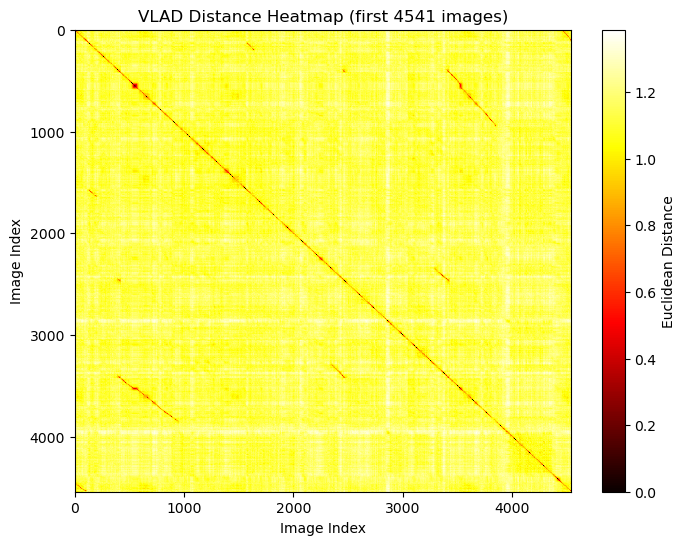

In [51]:
plot_embedding_distances_heatmap_subset(vlad_encodings, image_files, N=4541)

In [96]:
'''
Generate netvlad_result.txt, list top 20 similar images for each image
Python built-in sort function is called
'''
image_folder = kitti_dir
image_files = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png')])

# Specify the output file
output_file = "netvlad_result.txt"

# Compare each image with others and compute cosine similarity
similarity_scores = {}

for i in range(len(image_files)):
    if i % 200 == 100:
        print(f'{i} image has been processed')
        # break   #Early terminiation
    image_path_1 = image_files[i]
    vlad_encoding_1 = vlad_encodings[image_path_1]

    # Compute similarity between this image and all others
    scores = []
    for j in range(len(image_files)):
        # if i != j:
        if True:
            image_path_2 = image_files[j]
            vlad_encoding_2 = vlad_encodings[image_path_2]

            # Compute L2 norm as distance
            similarity = euclidean_distance(vlad_encoding_1, vlad_encoding_2)
            scores.append((image_path_2, similarity))

    # Sort the scores in descending order of similarity
    scores.sort(key=lambda x: x[1], reverse=False)
    
    # Store the top 20 results
    similarity_scores[image_path_1] = scores[:20]

# Output the top 20 results for each image
with open(output_file, "w") as f:
    for image_path, scores in similarity_scores.items():
        print(f"\nTop 20 most similar images to {os.path.basename(image_path)}:", file = f)
        for idx, (similar_image, score) in enumerate(scores):
            print(f"{idx + 1}. {os.path.basename(similar_image)} - Euclidean Distance: {score:.4f}", file = f)


100 image has been processed
300 image has been processed
500 image has been processed
700 image has been processed
900 image has been processed
1100 image has been processed
1300 image has been processed
1500 image has been processed
1700 image has been processed
1900 image has been processed
2100 image has been processed
2300 image has been processed
2500 image has been processed
2700 image has been processed
2900 image has been processed
3100 image has been processed
3300 image has been processed
3500 image has been processed
3700 image has been processed
3900 image has been processed
4100 image has been processed
4300 image has been processed
4500 image has been processed


In [54]:
kitti_dir = "/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/"

In [97]:
import os
import numpy as np
import faiss
'''
Faiss-acclerated sort
Faiss supports cpu/cuda, we use its cpu version
'''
# Your existing functions here:
# - extract_vlad_encoding_path() should return a PyTorch tensor or NumPy array of shape (D,).
# - euclidean_distance() won't be needed as FAISS will handle distance calculations.


def batch_vlad_encodings_cpu(image_folder=kitti_dir):
    """
    Extract VLAD encodings (as NumPy arrays) for all .png images in the specified folder.
    PyTorch tensors are converted to NumPy arrays on the CPU.
    
    :param image_folder: The path to the folder containing .png images.
    :return: A dictionary mapping image file paths to their VLAD encodings as NumPy arrays.
    """
    # Load all image file paths in the folder
    image_files = sorted([
        os.path.join(image_folder, img) 
        for img in os.listdir(image_folder) 
        if img.endswith('.png')
    ])

    # Ensure images were loaded
    if not image_files:
        print("No PNG images found in the directory.")
        exit(1)

    # Extract VLAD encodings for all images
    vlad_encodings = {}
    for image_file in image_files:
        # Example: returns a PyTorch tensor. If it's a tensor, we convert it to NumPy.
        enc = extract_vlad_encoding_path(image_file, compress=True, normalize=True).view(-1)
        
        # Convert to numpy if needed
        if hasattr(enc, 'detach'):
            enc = enc.detach().cpu().numpy()
        else:
            enc = np.array(enc)
        
        vlad_encodings[image_file] = enc
    
    return vlad_encodings

# Call vlad_encodiing function and move it to cpu memory 
vlad_encodings_cpu = batch_vlad_encodings_cpu()


In [99]:

print(f'How many images embedding? {len(vlad_encodings)}')

output_file = "netvlad_result_faiss.txt"

# Convert all VLAD encodings into a single NumPy array
embeddings = np.stack([vlad_encodings_cpu[img_path] for img_path in image_files], axis=0)
D = embeddings.shape[1]

# Build a FAISS index for efficient similarity search
# Here we use an IndexFlatL2 which gives exact nearest neighbors based on Euclidean distance.
# IndexFlatL2 is squared version of torch.dist()
index = faiss.IndexFlatL2(D)
index.add(embeddings)  # Add all embeddings to the index

# Query each image against the index
k = 20  # number of nearest neighbors you want
# Since we query against the same set, the image will find itself as the nearest neighbor at index 0.
distances, indices = index.search(embeddings, k)

# Write out the results
with open(output_file, "w") as f:
    for i, image_path in enumerate(image_files):
        print(f"\nTop {k} most similar images to {os.path.basename(image_path)}:", file=f)
        for rank, neighbor_idx in enumerate(indices[i]):
            similar_image_path = image_files[neighbor_idx]
            distance = distances[i, rank]
            print(f"{rank + 1}. {os.path.basename(similar_image_path)} - Euclidean Distance: {np.sqrt(distance):.4f}", file=f)


How many images embedding? 4541


***All codes beyond this point is not examined, use with caution***

In [38]:
# Specify the output file
output_file = "netvlad_result_bo1.txt"

# Compare each image with others and compute cosine similarity
similarity_scores = {}

similarity_list = []

for i in range(len(image_files)):
    if i % 1000 == 100:
        print(f'{i} image has been processed')
        # break   #Early terminiation
    image_path_1 = image_files[i]
    vlad_encoding_1 = vlad_encodings[image_path_1]

    # Compute similarity between this image and all others
    scores = []
    index_list = []
    for j in range(len(image_files)):
        # if i != j:
        if True:
            image_path_2 = image_files[j]
            vlad_encoding_2 = vlad_encodings[image_path_2]

            # Compute cosine similarity
            similarity = euclidean_distance(vlad_encoding_1, vlad_encoding_2)
            scores.append((image_path_2, similarity))
            index_list.append((j, similarity))

    # Sort the scores in descending order of similarity
    scores.sort(key=lambda x: x[1], reverse=False)
    index_list.sort(key=lambda x: x[1], reverse=False)

    # Store the top 20 results
    similarity_scores[image_path_1] = scores[:20]
    index_list_short = index_list[:10]

    #Process scores
    for matched_index, _ in index_list_short:
        if abs(matched_index - i) > 100:
            similarity_list.append([i, matched_index])
            break


TypeError: 'Tensor' object is not callable

In [30]:
similarity_list

NameError: name 'similarity_list' is not defined

In [ ]:
similarity_scores[image_files[999]]

[('/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000999.png',
  0.0),
 ('/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/001000.png',
  0.6510598659515381),
 ('/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000998.png',
  0.7143281698226929),
 ('/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000997.png',
  0.7724444270133972),
 ('/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/001001.png',
  0.8035771250724792),
 ('/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/000996.png',
  0.819719135761261),
 ('/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_gray/dataset/sequences/00/image_0/001002.png',
  0.8248560428619385),
 ('/home/ds/Research/lcd/orbslam3_do

In [ ]:
similarity_list

[[0, 4450],
 [1, 4451],
 [2, 4453],
 [3, 4453],
 [4, 4454],
 [5, 4455],
 [6, 4456],
 [7, 4457],
 [8, 4458],
 [9, 4459],
 [10, 4460],
 [11, 4461],
 [12, 4462],
 [13, 4463],
 [14, 4464],
 [15, 4465],
 [16, 4466],
 [17, 4467],
 [18, 4468],
 [19, 4469],
 [20, 4470],
 [21, 4471],
 [22, 4472],
 [23, 4473],
 [24, 4473],
 [25, 4474],
 [26, 4475],
 [27, 4476],
 [28, 4477],
 [29, 4478],
 [30, 4479],
 [31, 4480],
 [32, 4480],
 [33, 4482],
 [34, 4482],
 [35, 4483],
 [36, 4484],
 [37, 4485],
 [38, 4486],
 [39, 4487],
 [40, 4488],
 [41, 4489],
 [42, 4490],
 [43, 4490],
 [44, 4491],
 [45, 4492],
 [46, 4493],
 [47, 4494],
 [48, 4495],
 [49, 4496],
 [50, 4497],
 [51, 4497],
 [52, 4498],
 [53, 4499],
 [54, 4500],
 [55, 4501],
 [56, 4502],
 [57, 4503],
 [58, 4503],
 [59, 4504],
 [60, 4505],
 [61, 4506],
 [62, 4507],
 [63, 4508],
 [64, 4509],
 [65, 4509],
 [66, 4510],
 [67, 4511],
 [68, 4512],
 [69, 4512],
 [70, 4513],
 [71, 4514],
 [72, 4514],
 [73, 4515],
 [74, 4516],
 [75, 4516],
 [76, 4517],
 [77, 451